In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug  2 10:26:23 2018
This file constructs a strategic Equal-Risk portfolio and compare with an equal weighted portfolio.
@author: Steve Xia
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() 
import datetime 
from collections import OrderedDict
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [10]:

def cov_ewma(ret_assets, lamda = 0.94):
    ret_mat = ret_assets.values
    T = len(ret_assets)
    coeff = np.zeros((T,1))
    S = ret_assets.cov()
    for i in range(1, T):
#        S = lamda * S  + (1-lamda)*np.matmul(ret_mat[i-1,:].reshape((-1,1)), 
#                          ret_mat[i-1,:].reshape((1,-1)))
        S = lamda * S  + (1-lamda)* (ret_mat[i-1,:].reshape((-1,1)) @ ret_mat[i-1,:].reshape((1,-1)) )
        
        coeff[i] = (1-lamda)*lamda**(i)
    return S/np.sum(coeff)

In [11]:
# risk budgeting approach optimisation object function
def obj_fun(W, cov_assets, risk_budget):
    var_p = np.dot(W.transpose(), np.dot(cov_assets, W))
    sigma_p = np.sqrt(var_p)
    risk_contribution = W*np.dot(cov_assets, W)/sigma_p
    risk_contribution_percent = risk_contribution/sigma_p
    return np.sum((risk_contribution_percent-risk_budget)**2)

In [12]:
# calculate risk budgeting portfolio weight give risk budget
def riskparity_opt(ret_assets, risk_budget, lamda, method='ewma',Wts_min=0.0, leverage=False):
    # number of assets
    num_assets = ret_assets.shape[1]
    # covariance matrix of asset returns
    if method=='ewma':
        cov_assets = cov_ewma(ret_assets, lamda)
    elif method=='ma':
        cov_assets = ret_assets.cov()
    else:
        cov_assets = cov_ewma(ret_assets, lamda)        
    
    # initial weights
    w0 = 1.0 * np.ones((num_assets, 1)) / num_assets
    # constraints
    #cons = ({'type': 'eq', 'fun': cons_sum_weight}, {'type': 'ineq', 'fun': cons_long_only_weight})
    if leverage == True:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-2. }, # Sum of weights = 200%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    else:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }, # Sum of weights = 100%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    # portfolio optimisation
    return minimize(obj_fun, w0, args=(cov_assets, risk_budget), method='SLSQP', constraints=c_)

In [13]:
# function to get the price data from yahoo finance 
def getDataBatch(tickers, startdate, enddate):
  def getData(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map(getData, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

In [14]:
# function to get the return data calculated from price data 
# retrived from yahoo finance 
def getReturns(tickers, start_dt, end_dt, freq='monthly'): 
    px_data = getDataBatch(tickers, start_dt, end_dt)
    # Isolate the `Adj Close` values and transform the DataFrame
    px = px_data[['Adj Close']].reset_index().pivot(index='Date', 
                           columns='Ticker', values='Adj Close')
    if (freq=='monthly'):
        px = px.resample('M').last()
        
    # Calculate the daily/monthly percentage change
    ret = px.pct_change().dropna()
    
    ret.columns = tickers
    return(ret)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Ticker       AGG       PTH       XLK
Ticker                              
AGG     1.000000 -0.070325 -0.138241
PTH    -0.070325  1.000000  0.686102
XLK    -0.138241  0.686102  1.000000
sharpe ratio of different strategies:
 risk_parity    [0.7669850146456444]
equal_wted     [0.7669845744556857]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.7669850146456444]
XLK                        0.745772
AGG                        0.410175
PTH                        0.410175
dtype: object
asset risk Ticker
AGG    0.051532
PTH    0.225794
XLK    0.208700
dtype: float64
portfolio riskparity Risk Parity    0.132428
dtype: float64
portfolio riskEQwt Equal Weighted    0.132428
dtype: float64
asset return Ticker
AGG    0.038431
PTH    0.092615
XLK    0.108659
Name: 2017-12-2

<Figure size 432x288 with 0 Axes>

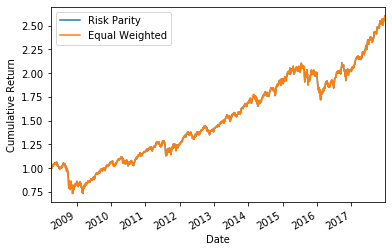

<Figure size 432x288 with 0 Axes>

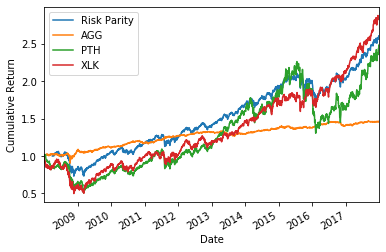

<Figure size 432x288 with 0 Axes>

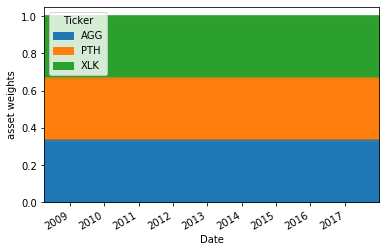

In [21]:
#%% get historical stock price data
if __name__ == "__main__":
    
    Flag_downloadData = True
    # define the time period 
    
    start_dt = datetime.datetime(2007, 12, 31)
    end_dt = datetime.datetime(2017, 12, 31)
   
        #
    Ticker_AllAsset = ['XLK', 'AGG', 'PTH']
    stock_data = getDataBatch(Ticker_AllAsset, start_dt, end_dt)
        # Isolate the `Adj Close` values and transform the DataFrame
    price_AllAsset = stock_data.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
   
   
    # 2. Calculate ARP excess returns
    ret_assets = price_AllAsset.pct_change().dropna()
    ret_assets_demean = ret_assets - ret_assets.mean()
    num_assets = ret_assets.shape[1]
    cor = ret_assets.corr()
    print(cor)
   
    lamda = 0.94
    SS = cov_ewma(ret_assets_demean, lamda)
    SS1 = cov_ewma(ret_assets, lamda)
    # Construct risk parity portfolio
    # portfolio dates - this defines the first date of portfolio construction
    datestr = ret_assets.index[ret_assets.index >= '2008-03-31']
    # previous month
    mth_previous = datestr[0]
    # initialise portfolio weights matrix
    wts = pd.DataFrame(index=datestr, columns=ret_assets.columns)
    # initialise portfolio return matrix
    ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])
    # how many rolling calendar days to use for covariance calculation
    window = 260
    Wts_min = 0.5
    risk_budget = 1.0/num_assets*np.ones([1,num_assets]) #risk-party
    #risk_budget = [0.7, 0.4]
    leverage = False
    varmodel = 'ma'
    
    
    for t in datestr:
        # construct risk budgeting portfolio and re-balance on monthly basis
        if t.month==mth_previous:
            # keep the same portfolio weights within the month
            wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
        else:
            # update the value of the previous month 
            mth_previous = t.month
            # re-balance the portfolio at the start of the month
            
            t_begin = t - timedelta(days=window)
            ret_used = ret_assets.loc[t_begin:t,:]
            wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
        # calculate risk budgeting portfolio returns
        ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_assets.loc[t])

        # Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
    wts[wts<0]=0.0
    # Construct equal weighted portfolio
    ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
    # Construct 60/40 weighted portfolio
    #ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
    
     #%%
    # Calculate performance stats
    ret_cumu_assets = (ret_assets + 1).cumprod()#done
    ret_cumu_riskP = (ret_riskParity + 1).cumprod() #done
    ret_cumu_equalwt = (ret_equalwted + 1).cumprod() #done
    
    ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1 #done
    std_annual_assets = ret_assets.std()*np.sqrt(250) #done
    sharpe_ratio_assets = ret_annual_assets/std_annual_assets #done
    
    ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1  #done
    std_annual_riskP = ret_riskParity.std()*np.sqrt(250) #done
    sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP #done
    
    ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1 #done
    std_annual_equalwt = ret_equalwted.std()*np.sqrt(250) #done
    sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt #done
    
    #sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
    sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
    sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('XLK', sharpe_ratio_assets[0]),
                     ('AGG', sharpe_ratio_assets[1]), ('PTH', sharpe_ratio_assets[1]),
                     )))
    print('sharpe ratio of different strategies:\n',sharpe_table)
    print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)
    print("asset risk", std_annual_assets)
    print("portfolio riskparity", std_annual_riskP)
    print("portfolio riskEQwt", std_annual_equalwt)
    print("asset return", ret_annual_assets)
    print("portfolio return riskparity", ret_annual_riskP)
    print("portfolio return EQwt", ret_annual_equalwt)
    #%%
    # compare the portfolio cumulative returns
    figure_count = 1
    plt.figure(figure_count)
    figure_count = figure_count+1
    pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
    plt.ylabel('Cumulative Return')
    plt.show()
    
    # compare the portfolio cumulative returns vs. asset returns
    plt.figure(figure_count)
    figure_count = figure_count+1
    pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
    plt.ylabel('Cumulative Return')
    plt.show()
    
    # plot the historical weights of the assets
    # area plot showing the weights
    plt.figure(figure_count)
    figure_count = figure_count + 1
    wts.plot.area()
    plt.ylabel('asset weights')

    
   